# Home Assignment 2

In [0]:
!wget http://paraphraser.ru/download/get?file_id=1

--2018-12-26 11:21:02--  http://paraphraser.ru/download/get?file_id=1
Resolving paraphraser.ru (paraphraser.ru)... 89.223.87.180
Connecting to paraphraser.ru (paraphraser.ru)|89.223.87.180|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1155237 (1.1M) [application/x-download]
Saving to: ‘get?file_id=1’

get?file_id=1       100%[===================>]   1.10M   518KB/s    in 2.2s    

2018-12-26 11:21:05 (518 KB/s) - ‘get?file_id=1’ saved [1155237/1155237]



In [0]:
! unzip get?file_id=1

Archive:  get?file_id=1
  inflating: LICENSE                 
  inflating: corpus.xml              
  inflating: paraphrases.xml         


In [0]:
!pip install pymorphy2

    100% |████████████████████████████████| 51kB 2.5MB/s 
    100% |████████████████████████████████| 7.1MB 6.4MB/s 


In [0]:
!pip install gensim

In [0]:
!pip install glove-python

    100% |████████████████████████████████| 266kB 8.9MB/s 
  Running setup.py bdist_wheel for glove-python ... - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/88/4b/6d/10c0d2ad32c9d9d68beec9694a6f0b6e83ab1662a90a089a4b
Successfully built glove-python


### Задание 1

Сначала импортируем данные из XML-файлов.

In [0]:
import xml.etree.ElementTree as ET
parser = ET.XMLParser(encoding = 'UTF-8')
tree = ET.parse('paraphrases.xml', parser = parser)
root = tree.getroot()

In [0]:
parser_corpus = ET.XMLParser(encoding = 'UTF-8')
tree_corpus = ET.parse('corpus.xml', parser = parser_corpus)
root_corpus = tree_corpus.getroot()

Чтобы избавиться от многоклассовости, присоединим класс '0' к классу '1'. Таким образом останется 2 класса - парафразы и не-парафразы. На этом же шаге мы сохраняем заголовки из файла с парами и из файла с общим корпусом.

In [0]:
import numpy as np
paraphrases, classes, corpus = [], [], []
for child in root[1]:
  paraphrases.append([child[3].text, child[4].text])
  classes.append(child[6].text)
classes = np.array([1 if i == '0' or i == '1' else 0 for i in classes])

for child in root_corpus[1]:
  corpus.append(child[1].text)

Отлично, мы вытащили предложения из xml. Положим потенциальные парафразы и их классы в один массив и попробуем их предобработать - убрать стоп-слова и лемматизировать.

In [0]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
from tqdm import tqdm
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem
mystem_analyzer = Mystem()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Installing mystem to /root/.local/bin/mystem from http://download.cdn.yandex.net/mystem/mystem-3.1-linux-64bit.tar.gz


Загруженный корпус с предобученными векторами содержит слова с добавленными к ним POS-тегами. Для работы с этими векторами сделаем токены с POS-тегами.

In [0]:
pym2 = MorphAnalyzer()
noise = stopwords.words('russian') + list(string.punctuation) + ['«', '»'] 
tokens, tokens_corpus, tokens_wo_pos, tokens_corpus_wo_pos = [], [], [], []
for i in paraphrases:
    tokens.append([[pym2.parse(j)[0].normal_form + '_' + str(pym2.parse(pym2.parse(j)[0].normal_form)[0].tag.POS)
                    for j in word_tokenize(i[0].lower()) if (j not in noise) and (pym2.parse(j)[0].tag.POS) is not None], 
                   [pym2.parse(j)[0].normal_form + '_' + str(pym2.parse(pym2.parse(j)[0].normal_form)[0].tag.POS)
                    for j in word_tokenize(i[1].lower()) if j not in noise and (pym2.parse(j)[0].tag.POS) is not None]])
for i in corpus:
  tokens_corpus.append([pym2.parse(j)[0].normal_form + '_' + str(pym2.parse(pym2.parse(j)[0].normal_form)[0].tag.POS)
                    for j in word_tokenize(i.lower()) if (j not in noise) and (pym2.parse(j)[0].tag.POS) is not None])
  

Теги из pymystem и универсальные POS-теги не совпадают - приведём теги к универсальному виду. Кроме того, сразу найдём индексы заголовков из пар в корпусе - это может пригодиться позже.

In [0]:
def replace_all(text, dic):
    for i, j in dic.items():
        text = text.replace(i, j)
    return text
d = {'_ADJF' : '_ADJ', '_ADJS' : '_ADJ', '_ADVB' : '_ADV', '_INFN' : '_VERB', '_PRTF' : '_ADJ', '_PRTS' : 'ADJ'}

index_in_corpus = np.array([])
for i in range(len(tokens_corpus)):
    for j in range(len(tokens_corpus[i])):
      tokens_corpus[i][j] = replace_all(tokens_corpus[i][j], d)

for i in range(len(tokens)):
  for j in range(len(tokens[i])):
    for k in range(len(tokens[i][j])):
      tokens[i][j][k] = replace_all(tokens[i][j][k], d)
    index_in_corpus = np.append(index_in_corpus, tokens_corpus.index(tokens[i][j]))
index_in_corpus = index_in_corpus.reshape(len(tokens), 2)
      


Загрузим модель с предобученными векторами и посчитаем WMD для пар векторов.

In [0]:
import gensim
import pymorphy2
import gensim.downloader as api

model_rus = api.load("word2vec-ruscorpora-300")

[==================================================] 100.0% 198.8/198.8MB downloaded


In [0]:
distances = np.array([])
for i in tokens:
  distances = np.append(distances, model_rus.wmdistance(i[0], i[1]))
distances[distances > 1.5] = 2

Найдем эмпирически лучший порог разделения парафразов от не-парафразов по дистанции.

In [0]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
for i in [0.65, 0.67, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.81, 0.83, 0.85]:
  distance_binary = [1 if j <= i else 0 for j in distances]
  print('threshold:', i)
  print('accuracy:', np.round(accuracy_score(classes, np.round(distance_binary)), 3))
  print('F1:', np.round(f1_score(classes, distance_binary, average = 'macro'), 3))

threshold: 0.65
accuracy: 0.743
F1: 0.717
threshold: 0.67
accuracy: 0.749
F1: 0.72
threshold: 0.69
accuracy: 0.754
F1: 0.721
threshold: 0.71
accuracy: 0.756
F1: 0.719
threshold: 0.73
accuracy: 0.759
F1: 0.717
threshold: 0.75
accuracy: 0.76
F1: 0.713
threshold: 0.77
accuracy: 0.761
F1: 0.709
threshold: 0.79
accuracy: 0.761
F1: 0.705
threshold: 0.81
accuracy: 0.762
F1: 0.702
threshold: 0.83
accuracy: 0.761
F1: 0.697
threshold: 0.85
accuracy: 0.762
F1: 0.695


А если бы мы обучились на корпусе и потом считали бы расстояние по его векторам? Было бы лучше? Сейчас посмотрим.

In [0]:
model = gensim.models.Word2Vec(
        tokens_corpus,
        size=150,
        window=5,
        min_count=1,
        workers=10)
model.train(tokens_corpus, total_examples=len(tokens_corpus), epochs=10)

(696018, 722830)

In [0]:
distances_local = np.array([])
for i in tokens:
  distances_local = np.append(distances_local, model.wmdistance(i[0], i[1]))
distances_local[distances_local > 1.5] = 2
for i in [0.85, 0.87, 0.89, 0.91, 0.93, 0.95, 0.97, 0.99, 1.01, 1.03, 1.05]:
  distance_binary = [1 if j <= i else 0 for j in distances_local]
  print('threshold:', i)
  print('accuracy:', np.round(accuracy_score(classes, np.round(distance_binary)), 3))
  print('F1:', np.round(f1_score(classes, distance_binary, average = 'macro'), 3))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `wmdistance` (Method will be removed in 4.0.0, use self.wv.wmdistance() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


threshold: 0.85
accuracy: 0.665
F1: 0.658
threshold: 0.87
accuracy: 0.671
F1: 0.663
threshold: 0.89
accuracy: 0.675
F1: 0.666
threshold: 0.91
accuracy: 0.679
F1: 0.668
threshold: 0.93
accuracy: 0.683
F1: 0.67
threshold: 0.95
accuracy: 0.687
F1: 0.673
threshold: 0.97
accuracy: 0.692
F1: 0.676
threshold: 0.99
accuracy: 0.695
F1: 0.677
threshold: 1.01
accuracy: 0.695
F1: 0.676
threshold: 1.03
accuracy: 0.7
F1: 0.678
threshold: 1.05
accuracy: 0.7
F1: 0.676


Нет, так не будет лучше :( 
Качество уступает предобученным на большом корпусе эмбеддингам.
Ниже финальный лучший результат.

In [0]:
distance_binary = [1 if j <= 0.75 else 0 for j in distances]
print('threshold:', 0.75)
print('accuracy:', np.round(accuracy_score(classes, np.round(distance_binary)), 3))
print('F1:', np.round(f1_score(classes, distance_binary, average = 'macro'), 3))

threshold: 0.75
accuracy: 0.76
F1: 0.713


### Задание 2

#### 2.1. Word2Vec, усредненные вектора

In [0]:
for i in range(len(tokens)):
  for j in range(len(tokens[i])):
    tokens[i][j] = [i for i in tokens[i][j] if i in model.wv.vocab.keys()]

In [0]:
w2v_avg = np.zeros(150).reshape(-1, 1)
for pairs in tokens:
  for i in pairs:
    w2v_avg = np.append(w2v_avg, np.mean(model[i], axis = 0).reshape(-1, 1), axis = 1)
w2v_avg = w2v_avg[:, 1:].reshape(len(tokens), 2, 150)
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [0]:
from scipy.spatial.distance import cosine
from scipy.stats import entropy
import pandas as pd

def vector_pair_features(vectors):
  cosine_dist, dot_product, entropia = [], [], []
  for i in vectors:
    cosine_dist.append(cosine(i[0], i[1]))
    dot_product.append(np.dot(i[0], i[1]))
  vectors_combined = vectors.reshape(-1, 300)
  df = pd.DataFrame(vectors_combined)
  df['cosine_dist'] = cosine_dist
  df['dot_product'] = dot_product

  return df
                        

In [0]:
df_w2vavg = vector_pair_features(w2v_avg)


In [0]:
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
def model_results(df, target):
  X_train, X_test, y_train, y_test = train_test_split(df.as_matrix(), target, test_size = 0.3, random_state = 1)
  xgb = XGBClassifier()
  xgb.fit(X_train, y_train)
  y_pred = xgb.predict(X_test)
  return 'accuracy:', np.round(accuracy_score(y_test, y_pred), 3), 'F1:', np.round(f1_score(y_test, y_pred, average = 'macro'), 3)

In [0]:
print(model_results(df_w2vavg, classes))

('accuracy:', 0.648, 'F1:', 0.436)


#### 2.2 FastText, усредненные вектора

In [0]:
from gensim.models import FastText
model_ft = FastText(
        tokens_corpus,
        size=150,
        window=5,
        min_count=1,
        workers=10)

In [0]:
ft_avg = np.zeros(150).reshape(-1, 1)
for pairs in tokens:
  for i in pairs:
    ft_avg = np.append(ft_avg, np.mean(model_ft[i], axis = 0).reshape(-1, 1), axis = 1)
ft_avg = ft_avg[:, 1:].reshape(len(tokens), 2, 150)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [0]:
model_results(vector_pair_features(ft_avg), classes)

('accuracy:', 0.654, 'F1:', 0.476)

#### 2.3 Doc2Vec

In [0]:
tokens_d2v = [' '.join(headline) for pairs in tokens for headline in pairs]
tokens_d2v[0]

'полицейский_NOUN разрешить_VERB стрелять_VERB поражение_NOUN гражданин_NOUN травматика_NOUN'

In [0]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = [TaggedDocument(words=word_tokenize(_d), tags=[str(i)]) for i, _d in enumerate(tokens_d2v)]
model_d2v = Doc2Vec(
        size=20,
        alpha=0.025, 
        min_alpha=0.00025,
        min_count=1,
        dm =1)

/usr/local/lib/python3.6/dist-packages/gensim/models/doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")


In [0]:
#model.build_vocab(tagged_data)

#### 2.4 Glove, усреднённые вектора

In [0]:
from glove import Corpus, Glove
corpus = Corpus() 
corpus.fit(tokens_corpus, window=5)
glove = Glove(no_components=150, learning_rate=0.05)
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
glove.save('glove.model')

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [0]:
glove_avg = np.zeros(150).reshape(-1, 1)
for i in range(len(tokens)):
  for j in range(len(tokens[0])):
    glove_avg = np.append(glove_avg, np.mean([glove.word_vectors[glove.dictionary[k]] for k in tokens[i][j]], axis = 0).reshape(-1, 1), axis = 1)
glove_avg = glove_avg[:, 1:].reshape(len(tokens), 2, 150)

In [0]:
model_results(vector_pair_features(glove_avg), classes)

('accuracy:', 0.645, 'F1:', 0.422)

#### 2.5 Word2vec, Tf-Idf

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
tfidf_sparse = tfidf.fit_transform([' '.join(i) for i in tokens_corpus])

In [0]:
tfi_df = pd.DataFrame(tfidf_sparse.todense(), index = list(range(len(tokens_corpus))), columns = tfidf.get_feature_names())

In [0]:
def tfidf_pair_vecs(model, tokens, tfi_df):
  vectors = np.zeros(150).reshape(-1, 1)
  for i in range(len(tokens)):
    for j in range(len(tokens[i])):
      headline_vector = np.zeros(150).reshape(-1, 1)
      for k in range(len(tokens[i][j])):

        word = tokens[i][j][k]

        if word.lower() in tfi_df.columns:
          tfidf_coef = tfi_df.loc[index_in_corpus[i][j]][word.lower()]
        else:
          tfidf_coef = 0

        headline_vector = np.sum((headline_vector, tfidf_coef * model[word].reshape(-1, 1)), axis = 0)

      vectors = np.vstack((vectors, headline_vector / len(tokens[i][j])))
  return vectors[150:].reshape(len(tokens), 2, 150)

In [0]:
w2v_tfidf = tfidf_pair_vecs(model, tokens, tfi_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [0]:
model_results(vector_pair_features(w2v_tfidf), classes)

('accuracy:', 0.747, 'F1:', 0.694)

#### 2.6 FastText, Tf-Idf

In [0]:
ft_tfidf = tfidf_pair_vecs(model_ft, tokens, tfi_df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


In [0]:
model_results(vector_pair_features(ft_tfidf), classes)

#### 2.7 Glove, Tf-Idf

In [0]:
glove_tfidf = np.zeros(150).reshape(-1, 1)
for i in range(len(tokens)):
  for j in range(len(tokens[i])):
    vector = np.zeros(150).reshape(-1, 1)
    for k in range(len(tokens[i][j])):
    
      word = tokens[i][j][k]

      if word.lower() in tfi_df.columns:
        tfidf_coef = tfi_df.loc[index_in_corpus[i][j]][word.lower()]
      else:
        tfidf_coef = 0
      vector = np.sum((vector, glove.word_vectors[glove.dictionary[word]].reshape(-1, 1)), axis = 0)
    glove_tfidf = np.append(glove_tfidf, vector / len(tokens[i][j]), axis = 1)
glove_tfidf = glove_tfidf[:, 1:].reshape(len(tokens), 2, 150)

In [0]:
model_results(vector_pair_features(glove_tfidf), classes)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


('accuracy:', 0.646, 'F1:', 0.427)

### Задание 3

Источники:

1) https://people.cs.umass.edu/~miyyer/pubs/2015_acl_dan.pdf

2) https://github.com/aravindsiv/dan_qa/blob/master/train.py

3) https://gist.github.com/mmmikael/0a3d4fae965bdbec1f9d

In [0]:
! pip install keras

In [0]:
! pip install tensorflow

In [0]:
import numpy as np

import keras 
import sys 
from keras import backend as K 
from keras.layers import *
from keras.models import Model, Sequential 
from keras.engine import InputSpec, Layer 
from keras import regularizers 
from keras.optimizers import SGD, Adam, Adagrad 
from keras.utils.conv_utils import conv_output_length 
from keras import activations 

In [0]:
embedding_dim = 150
num_hidden_layers = 3
num_hidden_units = 150
num_epochs = 100
batch_size = 100
dropout_rate = 0.2
word_dropout_rate = 0.3
activation = 'relu'

In [0]:
X_train, X_test, y_train, y_test = train_test_split(w2v_avg, classes, test_size = 0.3, random_state = 1)

In [0]:
X_train_left, X_train_right, X_test_left, X_test_right = X_train[:, 0, :], X_train[:, 1, :], X_test[:, 0, :], X_test[:, 1, :]
vec_left, vec_right = Input(shape=(1, 150)), Input(shape=(1, 150))
dense = Dense(300, activation=activation)
def siamese_dan(left_input, right_input, num_hidden_layers):
  model = Sequential()
  for i in range(num_hidden_layers):
    model.add(Dense(num_hidden_units))
    model.add(BatchNormalization())
    model.add(Activation('softmax'))
    model.add(Dropout(dropout_rate))

In [0]:
model1 = Sequential()
model1.add(Dense(num_hidden_units, input_shape = (None,150)))
model1.add(BatchNormalization())
model1.add(Dropout(dropout_rate))
for i in range(num_hidden_layers):
  model1.add(Dense(num_hidden_units))
  model1.add(BatchNormalization())
  model1.add(Dropout(dropout_rate))
  
model2 = Sequential()
model2.add(Dense(num_hidden_units, input_shape = (1,150)))
model2.add(BatchNormalization())
model2.add(Dropout(dropout_rate))
for i in range(num_hidden_layers):
  model2.add(Dense(num_hidden_units))
  model2.add(BatchNormalization())
  model2.add(Dropout(dropout_rate))

mergedOut = Add()([model1.output,model2.output])
mergedOut = Flatten()(mergedOut)
mergedOut = Dense(num_hidden_units)(mergedOut)    
mergedOut = BatchNormalization()(mergedOut)
mergedOut = Dropout(dropout_rate)(mergedOut)
mergedOut = Dense(5, activation='softmax')(mergedOut)

newModel = Model([model1.input,model2.input], mergedOut)

In [0]:
newModel.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Бонус

Ниже представим t-SNE представление усредненного Word2Vec

In [0]:
from sklearn.manifold import TSNE

In [0]:
X_tsne = TSNE(learning_rate=100).fit_transform(w2v_avg.reshape(7227*2, 150))

Визуализация следующая - выведем проекцию нескольких пар усредненных w2v-векторов для документов в двумерном пространстве. Белые точки - это проекции векторов-парафразов. Пары точек другого цвета - это проекции векторов-непарафразов. Видно, что проекции парафразов находятся ближе друг к другу.

Populating the interactive namespace from numpy and matplotlib


Text(0,0.5,'Dimension 2')

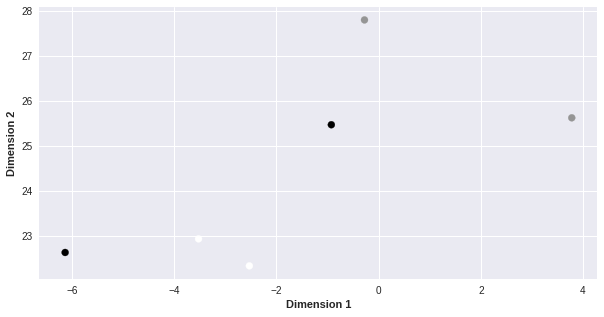

In [0]:
%pylab inline

figure(figsize=(10, 5))
#subplot(121)
scatter(X_tsne[14:20, 0], X_tsne[14:20, 1], c = [0, 0, 1, 1, 2, 2])
plt.xlabel('Dimension 1', weight='bold')
plt.ylabel('Dimension 2', weight='bold')

In [0]:
len(df_w2vavg)

7227

In [0]:
w2v_avg.shape

(7227, 2, 150)

In [0]:
paraphrases[0][0]

[['Полицейским разрешат стрелять на поражение по гражданам с травматикой.',
  'Полиции могут разрешить стрелять по хулиганам с травматикой.'],
 ['Право полицейских на проникновение в жилище решили ограничить.',
  'Правила внесудебного проникновения полицейских в жилище уточнят.'],
 ['Президент Египта ввел чрезвычайное положение в мятежных городах.',
  'Власти Египта угрожают ввести в стране чрезвычайное положение.'],
 ['Вернувшихся из Сирии россиян волнует вопрос трудоустройства на родине.',
  'Самолеты МЧС вывезут россиян из разрушенной Сирии.'],
 ['В Москву из Сирии вернулись 2 самолета МЧС с россиянами на борту.',
  'Самолеты МЧС вывезут россиян из разрушенной Сирии.'],
 ['Приставы соберут отпечатки пальцев российских должников.',
  'Приставы снимут отпечатки пальцев у злостных неплательщиков.'],
 ['На саратовского дебошира с борта самолета Москва - Хургада заведено дело.',
  'Саратовский дебошир отказывается возвращаться домой из Египта.'],
 ['ЦИК хочет отказаться от электронной си